# I. Algorithm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [4]:
import numpy as np

class Neural_Networks:
    def __init__(self, layer_sizes, learning_rate=0.01):
        '''
        layer_sizes: list of layer sizes in format [input_size, n1, n2, ..., output_size]
        '''
        self.lr = learning_rate
        self.num_layers = len(layer_sizes) - 1
        self.weights = []
        self.biases = []

        # Initialize weights and biases
        for i in range(self.num_layers):
            # in_size gives number of inputs at layer_i, out_size gives number of outputs after layer_i
            in_size = layer_sizes[i]
            out_size = layer_sizes[i+1]
            # Initialize weights according to the Kaiming He initialization rule
            self.weights.append(np.random.randn(in_size, out_size) * np.sqrt(2. / in_size))
            self.biases.append(np.zeros((1, out_size)))

    def sigmoid(self, x):
        '''
        Defines the sigmoid function
        '''
        return 1 / (1 + np.exp(-x))

    def sigmoid_deriv(self, x):
        '''
        Derivative of sigmoid function
        '''
        s = self.sigmoid(x)
        return s * (1 - s)
       
    def forward(self, X):
        '''
        Given input X value, outputs a prediction by the neural network through forward feeding
        '''
        self.zs = []
        self.activations = [X]
        a = X
        for i in range(self.num_layers - 1):  # Hidden layers
            z = a @ self.weights[i] + self.biases[i]
            a = self.sigmoid(z)
            self.zs.append(z)
            self.activations.append(a)
        # Output layer 
        z = a @ self.weights[-1] + self.biases[-1]
        a = self.sigmoid(z)
        self.zs.append(z)
        self.activations.append(a)
        return a  # output with sigmoid activation

    def backward(self, y_true, y_pred):
        '''
        Performs backwards propagation, updates weights given predicted y and actual y
        '''
        m = y_true.shape[0]
        grads_w = [None] * self.num_layers
        grads_b = [None] * self.num_layers
        
        # Computing output layer gradients 
        delta = (y_pred - y_true) / m
        grads_w[-1] = self.activations[-2].T @ delta
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

        # Backpropagation through hidden layers
        for i in reversed(range(self.num_layers - 1)):
            delta = (delta @ self.weights[i+1].T) * self.sigmoid_deriv(self.zs[i])
            grads_w[i] = self.activations[i].T @ delta
            grads_b[i] = np.sum(delta, axis=0, keepdims=True)

        # Update weights and biases
        for i in range(self.num_layers):
            self.weights[i] -= self.lr * grads_w[i]
            self.biases[i] -= self.lr * grads_b[i]

    def train(self, X, y, epochs=2000):
        '''
        Training the model given training X and y, keeping track of both training and testing error for each epoch
        '''
        train_errors = []
  
        for epoch in range(epochs):
            y_pred = self.forward(X)
            train_loss = np.mean((y - y_pred) ** 2)
            self.backward(y, y_pred)
            train_errors.append(train_loss)
 
        return train_errors
            


# II. Application to Data Set

In [5]:
# Loading in Data Set and Cleaning
game_data = pd.read_csv("../bgg_dataset.csv",delimiter=";")

game_data['Complexity Average'] = game_data['Complexity Average'].str.replace(',', '.').astype(float)
game_data['Rating Average'] = game_data['Rating Average'].str.replace(',', '.').astype(float)

# Selecting Columns of Top 100 Games
game_cleaned = game_data[['Rating Average','Complexity Average','Min Age','Play Time','BGG Rank']]
game_cleaned = game_cleaned[game_cleaned['BGG Rank'] <= 100]
game_cleaned.dropna(inplace = True)

# Labelling short games as those where play time is less than or equal to 60 minutes
game_cleaned['short'] = np.where(game_cleaned['Play Time'] <= 60, 1, 0)


We will use ```'Rating Average'```, ```'Complexity Average'```, and ```'Min Age'``` to predict whether the game is short or long. Let's first use histograms to look at the distribution of our data.

The average rating of short games is: 7.87 out of 10.
The average rating of long games is: 8.1 out of 10.


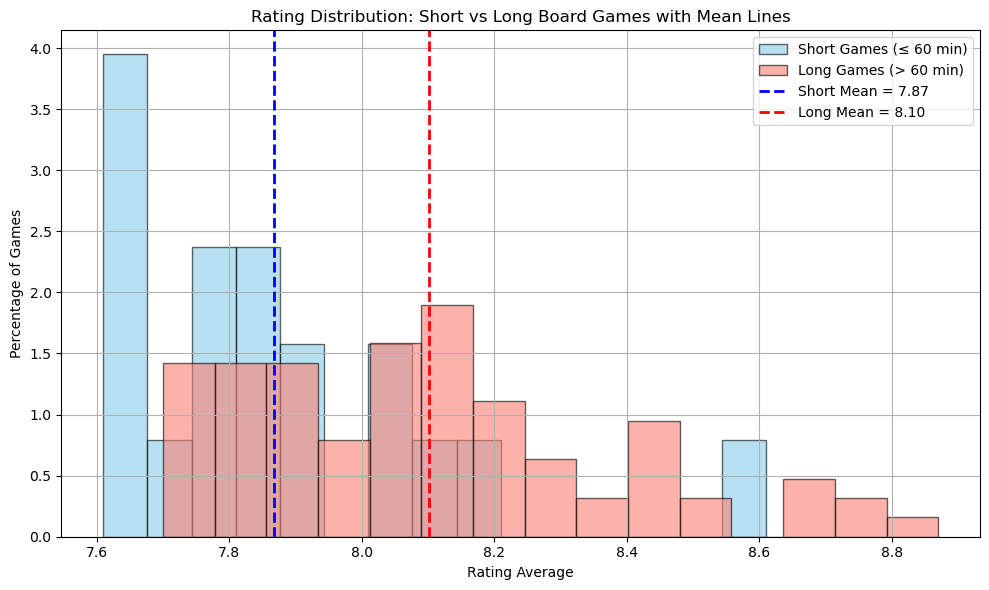

In [6]:
# Split the data
short_games = game_cleaned[game_cleaned['short'] == 1]
long_games = game_cleaned[game_cleaned['short'] == 0]

# Calculate means
short_mean = short_games['Rating Average'].mean()
long_mean = long_games['Rating Average'].mean()

print(f'The average rating of short games is: {round(short_mean,2)} out of 10.')
print(f'The average rating of long games is: {round(long_mean,2)} out of 10.')

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(short_games['Rating Average'], bins=15, alpha=0.6, label='Short Games (≤ 60 min)', color='skyblue', edgecolor='black', density = True)
plt.hist(long_games['Rating Average'], bins=15, alpha=0.6, label='Long Games (> 60 min)', color='salmon', edgecolor='black', density = True)

# Add vertical mean lines
plt.axvline(short_mean, color='blue', linestyle='dashed', linewidth=2, label=f'Short Mean = {short_mean:.2f}')
plt.axvline(long_mean, color='red', linestyle='dashed', linewidth=2, label=f'Long Mean = {long_mean:.2f}')

# Labels and title
plt.xlabel('Rating Average')
plt.ylabel('Percentage of Games')
plt.title('Rating Distribution: Short vs Long Board Games with Mean Lines')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We see that short games have a very skewed right distribution whereas longer board games have a more uniform distribution with a slight right skew. Short games have on average a lower rating than longer games. 

The average complexity of short games is: 2.34 out of 10.
The average complexity of long games is: 3.52 out of 10.


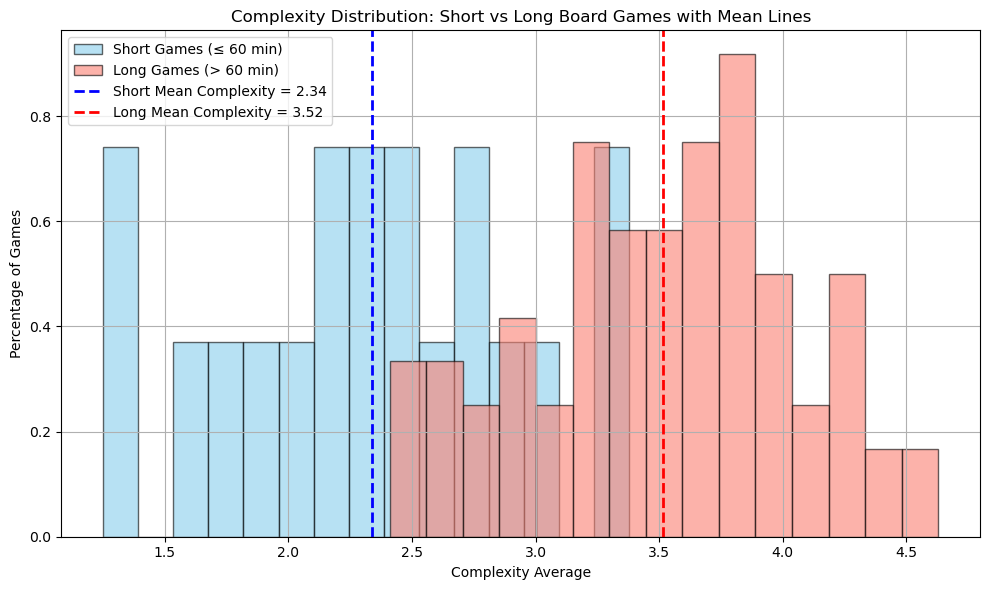

In [7]:
# Calculate means
short_complexity = short_games['Complexity Average'].mean()
long_complexity = long_games['Complexity Average'].mean()

print(f'The average complexity of short games is: {round(short_complexity,2)} out of 10.')
print(f'The average complexity of long games is: {round(long_complexity,2)} out of 10.')

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(short_games['Complexity Average'], bins=15, alpha=0.6, label='Short Games (≤ 60 min)', color='skyblue', edgecolor='black', density = True)
plt.hist(long_games['Complexity Average'], bins=15, alpha=0.6, label='Long Games (> 60 min)', color='salmon', edgecolor='black', density = True)

# Add vertical mean lines
plt.axvline(short_complexity, color='blue', linestyle='dashed', linewidth=2, label=f'Short Mean Complexity = {short_complexity:.2f}')
plt.axvline(long_complexity, color='red', linestyle='dashed', linewidth=2, label=f'Long Mean Complexity = {long_complexity:.2f}')

# Labels and title
plt.xlabel('Complexity Average')
plt.ylabel('Percentage of Games')
plt.title('Complexity Distribution: Short vs Long Board Games with Mean Lines')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We see that longer games have a clear higher complexity level compared to shorter games. Short games have a roughly uniform distribution whereas long games have more of a uniform distribution with a peak around 3.7.

Now that we've looked at distributions, let's fit our Neural Networks model.

In [12]:
# Preparing data 
X = game_cleaned[['Rating Average', 'Complexity Average','Min Age']].to_numpy()
y = game_cleaned['short'].to_numpy()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

#Scale the features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the neural network with 10 nodes in hidden layer
model = Neural_Networks(layer_sizes = [3, 10, 1])
train_errors = model.train(X_train_scaled, y_train.reshape(-1,1))


Let's look at how fast our algorithm converges by plotting squared error against epoch.

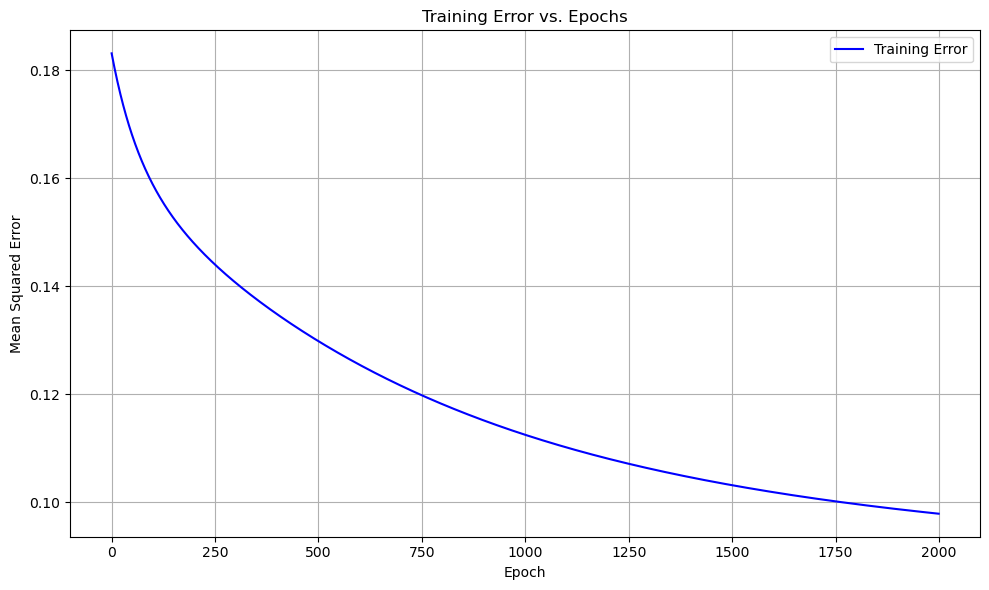

In [13]:
# Plotting training error vs. epochs
epochs = np.arange(len(train_errors))  
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_errors, label='Training Error', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Error vs. Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We see an exponential decay in the error. By the time we get to epoch 2000, our training error is very low.

In [14]:
# Evaluate the model
y_pred = model.forward(X_test_scaled)
y_pred_labels = (y_pred >= 0.5).astype(int)
print(f"Accuracy: {accuracy_score(y_test, y_pred_labels)}")
print("Classification Report:\n", classification_report(y_test, y_pred_labels))


Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.75      0.86         4

    accuracy                           0.95        20
   macro avg       0.97      0.88      0.91        20
weighted avg       0.95      0.95      0.95        20



Looking at the classification report, we see that our neural network is very accurate. The recall for long roller coasters is very high at 100%. Ultimately, this is much better than the simple perceptron model, which only worked for linearly separable data. By including a hidden layer and a non-linear sigmoid function, we were able to achieve much higher accuracy.

Text(0, 0.5, 'Frequency')

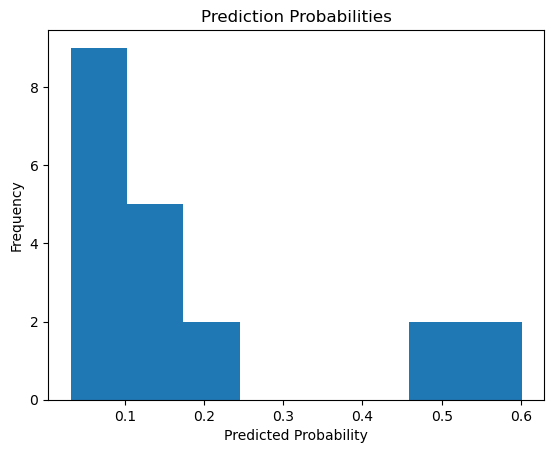

In [91]:
# Plotting distriution of prediction probabilities
plt.hist(y_pred, bins=8)
plt.title('Prediction Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

This gives us a histogram of predicted probabilities that a board game is short. We see a right skew and this makes sense since most board games have shorter play times. 